# Overview
This notebook continues the analysis of the term vectors. 

# Compare global and local TF-IDF
For description of steps, see paper. 

## Flickr

In [1]:

#
# steps 1-3
# 

import numpy
from collections import Counter
import psycopg2

# variable declarations -- all VARIABLES are input arguments
CONN_DB = ""
PATH = "/path/to/working/directory/"
INPUT_FILES_NAMES = ["flickr_global_tfidf_array.npy", "flickr_local_tfidf_array.npy"]
OUTPUT_FILES_NAMES = ["flickr_global_", "flickr_local_"]
TERM_FILE = "terms_stemmed.txt"
# how many Top ranks to consider in the analysis, i.e. "Top-33 terms"; 
TOP = 5 

# fetch MSOA ids
# 'order by' important for local TF-IDF and linking back results to spatial units
con=psycopg2.connect(CONN_DB)
cur=con.cursor()
cur2=con.cursor()
cur.execute('SELECT DISTINCT msoa2011code FROM london_flickr ORDER BY msoa2011code') 
query_result = cur.fetchall() 


for i in range(len(INPUT_FILES_NAMES)):
    
    print("Starting with " + INPUT_FILES_NAMES[i])
    # input array [MSOA[termscore,...],...]
    # load data from previous steps
    arr = numpy.load(PATH+INPUT_FILES_NAMES[i])

    #
    # Step 1
    #
    
    # rank (sort) scores per row (MSOAs)
    # output [MSOA[rank[indexofterm, valueofterm],...], ...] 
    lst1 = []
    for y in range(len(arr)):
        lst2 = []
        for x in sorted(range(len(arr[y])), key=lambda k: arr[y][k], reverse = True):
            lst2.append([x,arr[y][x]])
        lst1.append(lst2)
    print("DONE rank (sorted) scores per row (MSOAs)")
    
    # pick Top X terms, e.g. first X ranks per MSOA
    # output [MSOA[rank[indexofterm, valueofterm],...], ...]
    lst3 = []
    for y in range(len(lst1)):
        lst4 = []
        for x in range(TOP): 
            lst4.append(lst1[y][x])
        lst3.append(lst4)
    print("DONE Top-X ranks per MSOA")
    
    #
    # Step 2
    # 
    
    # find term indices per Top-X rank of all MSOAs
    # output [rank1[MSOA1_indexofterm_rank1, MSOA2_indexofterm_rank1, ...], rank2[MSOA1_indexofterm_rank2, ...], ...]
    lst5 = []
    for x in range(len(lst3[0])):
        lst6 = []
        for y in range(len(lst3)):
            lst6.append(lst3[y][x][0])
        lst5.append(lst6)    
    print("DONE terms per Top-X rank")
    
    # count frequency of terms per Top-X rank
    # output [rank1{indexofterm:frequency, ...},rank2{...}, ...]
    dctlst = []
    for y in range(len(lst5)):
        dctlst.append(dict(Counter(lst5[y])))
    print("DONE frequency of terms per Top-X rank")
    
   
    # pick ranks per term if in Top-X ranks for an MSOA
    # output [indexofterm[rank, ...],  ...]
    lst7 = []
    for x in range(len(arr[0])): # iterate over number of terms
        lst8 = []
        for y in range(len(lst3)): # iterate over number of MSOAs
            for z in range(len(lst3[y])): # iterate over Top-X ranks in each MSOA
                if lst3[y][z][0] == x: # if current Top-X rank of MSOA is the current term, then
                    lst8.append(z)  # add its rank to list
        lst7.append(lst8)    
    print("DONE Top-X ranks per term")
      
    # count Top-X ranks and their sum per term
    # output array[indexofterm[rank, ..., totalranks],...]
    dtype=[('r1',int),('r2',int),('r3',int),('r4',int),('r5',int),('totalr',int),('termidx',int)] 
    arr9=numpy.zeros((len(arr[0]),),dtype=dtype)
    for x in range(len(arr[0])): # iterate over number of terms
        totalranks=0
        for y in range(len(lst3)): # iterate over number of MSOAs
            for z in range(len(lst3[y])): # iterate over ranks in MSOA
                if lst3[y][z][0] == x: # if current Top-X rank of MSOA is the current term, then
                    arr9[x][z]=arr9[x][z]+1 # increase count by 1
                    totalranks=totalranks+(len(lst3[y])-z) # increase totalranks by reverse ranks, i.e. Top-1 scores Top-X
        arr9[x][-2]=arr9[x][-2]+totalranks
        arr9[x][-1]=arr9[x][-1]+x
    
    # only structured array can be sorted, but it needs tuples...
    arr10=numpy.core.records.fromrecords(arr9,names='r1,r2,r3,r4,r5,totalr,termidx',formats='i4,i4,i4,i4,i4,i4,i4')
    arr11=numpy.sort(arr10, order='totalr') # apparently cannot sort in reverse order
    print("DONE sorted totalranks per term")
    
    #
    # outputs
    #
    
    # output top scores per MSOA (step 1)
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"MSOA_top"+str(TOP)+"_scores.csv", 'w')
    out_file_handle.write("MSOA,T1,S1,T2,S2,T3,S3,T4,S4,T5,S5\n")
    msoa_counter=0
    for msoa in query_result[:-1]:
        out_file_line =str(msoa[0])
        for x in range(TOP):
            out_file_line = out_file_line+','+str(lst3[msoa_counter][x][0])+','+str(lst3[msoa_counter][x][1])
        out_file_handle.write(out_file_line+'\n')
        msoa_counter+=1
    out_file_handle.close()
    
    # output summed Top-X ranks for all terms (step 2)
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"top"+str(TOP)+"_MSOA_ranked.csv", 'w')
    out_file_handle.write("totalranks,termindex,term\n")
    term_dict = {}
    term_dict_key = 0
    in_file_handle = open(PATH + TERM_FILE)
    for line in in_file_handle:
        term_dict[term_dict_key] = [line.rstrip()]
        term_dict_key += 1
    in_file_handle.close()
    for x in range(len(arr11)):
        rev_idx = len(arr11)-x-1 # reverse sorting, highest totalranks first
        out_file_line = str(arr11[rev_idx][-2]) + "," + str(arr11[rev_idx][-1]) + "," + str(term_dict[arr11[rev_idx][-1]][0] + "\n")
        out_file_handle.write(out_file_line)
    out_file_handle.close()    
    
    # output the scores for the overall Top-X terms, per MSOA (step 3)
    lst12=[]
    for x in range(TOP):
        rev_idx = len(arr11)-x-1 # reverse sorting, highest first
        lst12.append(arr11[rev_idx][-1])   
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"overall_top"+str(TOP)+"_scores.csv", 'w')
    out_file_line = "MSOA"
    for term_idx in lst12:
        out_file_line = out_file_line+','+str(term_dict[term_idx][0])
    out_file_handle.write(out_file_line+'\n')
    msoa_counter=0
    for msoa in query_result[:-1]:
        out_file_line =str(msoa[0])
        for term_idx in lst12:
            out_file_line = out_file_line+','+str(arr[msoa_counter][term_idx])
        out_file_handle.write(out_file_line+'\n')
        msoa_counter+=1
    out_file_handle.close()

Starting with flickr_global_tfidf_array.npy
DONE rank (sorted) scores per row (MSOAs)
DONE Top-X ranks per MSOA
DONE terms per Top-X rank
DONE frequency of terms per Top-X rank
DONE Top-X ranks per term
DONE sorted totalranks per term
Starting with flickr_local_tfidf_array.npy
DONE rank (sorted) scores per row (MSOAs)
DONE Top-X ranks per MSOA
DONE terms per Top-X rank
DONE frequency of terms per Top-X rank
DONE Top-X ranks per term
DONE sorted totalranks per term


In [2]:
#
# comparison for step 4
# 

import numpy
import psycopg2
from scipy import stats
import pandas as pd

# variable declarations -- all VARIABLES are input arguments
CONN_DB = ""
PATH = "/path/to/working/directory/"
INPUT_FILES = ["flickr_global_tfidf_array.npy", "flickr_local_tfidf_array.npy"]
OUTPUT_FILE = "flickr_TF-IDF_stats_glocal.csv"
SIGNIF = 0.01 # significance level for normality test for paired z-test

# fetch msoa ids
# 'order by' statement important for local TF-IDF and linking back results to spatial units
con=psycopg2.connect(CONN_DB)
cur=con.cursor()
cur.execute('SELECT DISTINCT msoa2011code FROM london_flickr ORDER BY msoa2011code') 
query_result = cur.fetchall() 

arr = numpy.load(PATH+INPUT_FILES[0])
arr2 = numpy.load(PATH+INPUT_FILES[1])

# output stat scores using all terms, per MSOA (combining options 1 and 2 in one go)
out_file_handle = open(PATH+OUTPUT_FILE, 'w')
out_file_line = "MSOA, spearmanr, spearmanr_p, wilcoxon, wilcoxon_p, rel_ttest, rel_ttest_p"
out_file_handle.write(out_file_line+'\n')
msoa_counter=0
for msoa in query_result[:-1]:
    out_file_line = str(msoa[0])+","
    result = stats.spearmanr(arr[msoa_counter],arr2[msoa_counter])
    out_file_line += format(result.correlation, '.4f')+','+format(result.pvalue, '.4f')+','
    result = stats.wilcoxon(arr[msoa_counter],arr2[msoa_counter])
    out_file_line += format(result.statistic, '.4f')+','+format(result.pvalue, '.4f')+','
    result = stats.normaltest(arr[msoa_counter])
    if result.pvalue<SIGNIF:
        result = stats.normaltest(arr2[msoa_counter])
        if result.pvalue<SIGNIF:
            result = stats.ttest_rel(arr[msoa_counter],arr2[msoa_counter])
            out_file_line += format(result.statistic, '.4f')+','+format(result.pvalue, '.4f')
        else:
            out_file_line += ','
    else:
        out_file_line += ','
    out_file_handle.write(out_file_line+'\n')
    msoa_counter+=1
out_file_handle.close()

In [3]:
# summarize correlation statistics over all MSOAs
flickr_glocal_stats = pd.read_csv(PATH+OUTPUT_FILE)
flickr_glocal_stats.describe()

,spearmanr,spearmanr_p,wilcoxon,wilcoxon_p,rel_ttest,rel_ttest_p
count,983.000000,983.0,983.000000,983.000000,983.000000,983.000000
mean,0.997616,0.0,11399.471007,0.089699,-0.388347,0.246524
std,0.001619,0.0,9602.014194,0.212886,2.527684,0.299611
min,0.988800,0.0,58.000000,0.000000,-9.781600,0.000000
25%,0.996950,0.0,3716.500000,0.000000,-2.046950,0.003750
50%,0.997900,0.0,9064.000000,0.000000,-0.462900,0.104400
75%,0.998700,0.0,16356.500000,0.024400,1.240550,0.427700
max,1.000000,0.0,51017.000000,0.991700,8.213200,0.998200


In [4]:
# calculate correlation global-local of summed Top-X ranks (totalranks) per term (from Step 2)
flickr_global_ranks = pd.read_csv(PATH+'flickr_global_top5_MSOA_ranked.csv').sort_values(by=['termindex'])['totalranks'].to_numpy()
flickr_local_ranks = pd.read_csv(PATH+'flickr_local_top5_MSOA_ranked.csv').sort_values(by=['termindex'])['totalranks'].to_numpy()
tau, p = stats.kendalltau(flickr_global_ranks, flickr_local_ranks)
print(tau,p)

0.8857448514145794 9.018881443397436e-169


In [6]:
# exclude terms without any Top-X rankings
combined_ranks = pd.merge(pd.read_csv(PATH+'flickr_global_top5_MSOA_ranked.csv'),pd.read_csv(PATH+'flickr_local_top5_MSOA_ranked.csv'),on='termindex')
combined_ranks2 = combined_ranks[(combined_ranks['totalranks_x'] > 0) & (combined_ranks['totalranks_y'] > 0) ]
tau, p = stats.kendalltau(combined_ranks2['totalranks_x'], combined_ranks2['totalranks_y'])
print(tau,p)
print(combined_ranks2[:10])

0.8696552956041488 5.6796942804699076e-139
   totalranks_x  termindex    term_x  totalranks_y    term_y
0           837        102      park           925      park
1           534        136      road           665      road
2           459        124   station           496   station
3           326        165      hill           330      hill
4           307        157     squar           378     squar
5           286        105    garden           340    garden
6           256        174  cemeteri           249  cemeteri
7           237          3       wed           245       wed
8           234        100     river           222     river
9           233        103    street           282    street


## Twitter

In [7]:
#
# steps 1-3
# 

import numpy
from collections import Counter
import psycopg2

# variable declarations -- all VARIABLES are input arguments
CONN_DB = ""
PATH = "/path/to/working/directory/"
INPUT_FILES_NAMES = ["twitter_global_tfidf_array.npy", "twitter_local_tfidf_array.npy"]
OUTPUT_FILES_NAMES = ["twitter_global_", "twitter_local_"]
TERM_FILE = "terms_stemmed.txt"
# how many Top ranks to consider in the analysis, i.e. "Top-33 terms"
TOP = 5 

# fetch MSOA ids
# 'order by' important for local TF-IDF and linking back results to spatial units
con=psycopg2.connect(CONN_DB)
cur=con.cursor()
cur2=con.cursor()
cur.execute('SELECT DISTINCT msoa2011code FROM london_twitter ORDER BY msoa2011code') 
query_result = cur.fetchall() 


for i in range(len(INPUT_FILES_NAMES)):
    
    print("Starting with " + INPUT_FILES_NAMES[i])
    # input array [MSOA[termscore,...],...]
    # load data from previous steps
    arr = numpy.load(PATH+INPUT_FILES_NAMES[i])

    #
    # Step 1
    #
    
    # rank (sort) scores per row (MSOAs)
    # output [MSOA[rank[indexofterm, valueofterm],...], ...] 
    lst1 = []
    for y in range(len(arr)):
        lst2 = []
        for x in sorted(range(len(arr[y])), key=lambda k: arr[y][k], reverse = True):
            lst2.append([x,arr[y][x]])
        lst1.append(lst2)
    print("DONE rank (sorted) scores per row (MSOAs)")
    
    # pick Top X terms, e.g. first X ranks per MSOA
    # output [MSOA[rank[indexofterm, valueofterm],...], ...]
    lst3 = []
    for y in range(len(lst1)):
        lst4 = []
        for x in range(TOP): 
            lst4.append(lst1[y][x])
        lst3.append(lst4)
    print("DONE Top-X ranks per MSOA")
    
    #
    # Step 2
    # 
    
    # find term indices per Top-X rank of all MSOAs
    # output [rank1[MSOA1_indexofterm_rank1, MSOA2_indexofterm_rank1, ...], rank2[MSOA1_indexofterm_rank2, ...], ...]
    lst5 = []
    for x in range(len(lst3[0])):
        lst6 = []
        for y in range(len(lst3)):
            lst6.append(lst3[y][x][0])
        lst5.append(lst6)    
    print("DONE terms per Top-X rank")
    
    # count frequency of terms per Top-X rank
    # output [rank1{indexofterm:frequency, ...},rank2{...}, ...]
    dctlst = []
    for y in range(len(lst5)):
        dctlst.append(dict(Counter(lst5[y])))
    print("DONE frequency of terms per Top-X rank")
    
   
    # pick ranks per term if in Top-X ranks for an MSOA
    # output [indexofterm[rank, ...],  ...]
    lst7 = []
    for x in range(len(arr[0])): # iterate over number of terms
        lst8 = []
        for y in range(len(lst3)): # iterate over number of MSOAs
            for z in range(len(lst3[y])): # iterate over Top-X ranks in each MSOA
                if lst3[y][z][0] == x: # if current Top-X rank of MSOA is the current term, then
                    lst8.append(z)  # add its rank to list
        lst7.append(lst8)    
    print("DONE Top-X ranks per term")
      
    # count Top-X ranks and their sum per term
    # output array[indexofterm[rank, ..., totalranks],...]
    dtype=[('r1',int),('r2',int),('r3',int),('r4',int),('r5',int),('totalr',int),('termidx',int)] 
    arr9=numpy.zeros((len(arr[0]),),dtype=dtype)
    for x in range(len(arr[0])): # iterate over number of terms
        totalranks=0
        for y in range(len(lst3)): # iterate over number of MSOAs
            for z in range(len(lst3[y])): # iterate over ranks in MSOA
                if lst3[y][z][0] == x: # if current Top-X rank of MSOA is the current term, then
                    arr9[x][z]=arr9[x][z]+1 # increase count by 1
                    totalranks=totalranks+(len(lst3[y])-z) # increase totalranks by reverse ranks, i.e. Top-1 scores Top-X
        arr9[x][-2]=arr9[x][-2]+totalranks
        arr9[x][-1]=arr9[x][-1]+x
    
    # only structured array can be sorted, but it needs tuples...
    arr10=numpy.core.records.fromrecords(arr9,names='r1,r2,r3,r4,r5,totalr,termidx',formats='i4,i4,i4,i4,i4,i4,i4')
    arr11=numpy.sort(arr10, order='totalr') # apparently cannot sort in reverse order
    print("DONE sorted totalranks per term")
    
    #
    # outputs
    #
    
    # output top scores per MSOA (step 1)
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"MSOA_top"+str(TOP)+"_scores.csv", 'w')
    out_file_handle.write("MSOA,T1,S1,T2,S2,T3,S3,T4,S4,T5,S5\n")
    msoa_counter=0
    for msoa in query_result[:-1]:
        out_file_line =str(msoa[0])
        for x in range(TOP):
            out_file_line = out_file_line+','+str(lst3[msoa_counter][x][0])+','+str(lst3[msoa_counter][x][1])
        out_file_handle.write(out_file_line+'\n')
        msoa_counter+=1
    out_file_handle.close()
    
    # output summed Top-X ranks for all terms (step 2)
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"top"+str(TOP)+"_MSOA_ranked.csv", 'w')
    out_file_handle.write("totalranks,termindex,term\n")
    term_dict = {}
    term_dict_key = 0
    in_file_handle = open(PATH + TERM_FILE)
    for line in in_file_handle:
        term_dict[term_dict_key] = [line.rstrip()]
        term_dict_key += 1
    in_file_handle.close()
    for x in range(len(arr11)):
        rev_idx = len(arr11)-x-1 # reverse sorting, highest totalranks first
        out_file_line = str(arr11[rev_idx][-2]) + "," + str(arr11[rev_idx][-1]) + "," + str(term_dict[arr11[rev_idx][-1]][0] + "\n")
        out_file_handle.write(out_file_line)
    out_file_handle.close()    
    
    # output the scores for the overall Top-X terms, per MSOA (step 3)
    lst12=[]
    for x in range(TOP):
        rev_idx = len(arr11)-x-1 # reverse sorting, highest first
        lst12.append(arr11[rev_idx][-1])   
    out_file_handle = open(str(PATH)+str(OUTPUT_FILES_NAMES[i])+"overall_top"+str(TOP)+"_scores.csv", 'w')
    out_file_line = "MSOA"
    for term_idx in lst12:
        out_file_line = out_file_line+','+str(term_dict[term_idx][0])
    out_file_handle.write(out_file_line+'\n')
    msoa_counter=0
    for msoa in query_result[:-1]:
        out_file_line =str(msoa[0])
        for term_idx in lst12:
            out_file_line = out_file_line+','+str(arr[msoa_counter][term_idx])
        out_file_handle.write(out_file_line+'\n')
        msoa_counter+=1
    out_file_handle.close()

Starting with twitter_global_tfidf_array.npy
DONE rank (sorted) scores per row (MSOAs)
DONE Top-X ranks per MSOA
DONE terms per Top-X rank
DONE frequency of terms per Top-X rank
DONE Top-X ranks per term
DONE sorted totalranks per term
Starting with twitter_local_tfidf_array.npy
DONE rank (sorted) scores per row (MSOAs)
DONE Top-X ranks per MSOA
DONE terms per Top-X rank
DONE frequency of terms per Top-X rank
DONE Top-X ranks per term
DONE sorted totalranks per term


In [8]:
#
# comparison for step 4
# 

import numpy
import psycopg2
from scipy import stats
import pandas as pd

# variable declarations -- all VARIABLES are input arguments
CONN_DB = ""
PATH = "/path/to/working/directory/"
INPUT_FILES = ["twitter_global_tfidf_array.npy", "twitter_local_tfidf_array.npy"]
OUTPUT_FILE = "twitter_TF-IDF_stats_glocal.csv"
SIGNIF = 0.01

# fetch msoa ids
# 'order by' important for local TF-IDF and linking back results to spatial units
con=psycopg2.connect(CONN_DB)
cur=con.cursor()
cur.execute('SELECT DISTINCT msoa2011code FROM london_twitter ORDER BY msoa2011code') 
query_result = cur.fetchall() 

arr = numpy.load(PATH+INPUT_FILES[0])
arr2 = numpy.load(PATH+INPUT_FILES[1])

# output stat scores using all terms, per MSOA (combining options 1 and 2 in one go)
out_file_handle = open(PATH+OUTPUT_FILE, 'w')
out_file_line = "MSOA, spearmanr, spearmanr_p, wilcoxon, wilcoxon_p, rel_ttest, rel_ttest_p"
out_file_handle.write(out_file_line+'\n')
msoa_counter=0
for msoa in query_result[:-1]:
    out_file_line = str(msoa[0])+","
    result = stats.spearmanr(arr[msoa_counter],arr2[msoa_counter])
    out_file_line += format(result.correlation, '.4f')+','+format(result.pvalue, '.4f')+','
    result = stats.wilcoxon(arr[msoa_counter],arr2[msoa_counter])
    out_file_line += format(result.statistic, '.4f')+','+format(result.pvalue, '.4f')+','
    result = stats.normaltest(arr[msoa_counter])
    if result.pvalue<SIGNIF:
        result = stats.normaltest(arr2[msoa_counter])
        if result.pvalue<SIGNIF:
            result = stats.ttest_rel(arr[msoa_counter],arr2[msoa_counter])
            out_file_line += format(result.statistic, '.4f')+','+format(result.pvalue, '.4f')
        else:
            out_file_line += ','
    else:
        out_file_line += ','
    out_file_handle.write(out_file_line+'\n')
    msoa_counter+=1
out_file_handle.close()

In [9]:
# summarize correlation statistics over all MSOAs
twitter_glocal_stats = pd.read_csv(PATH+OUTPUT_FILE)
twitter_glocal_stats.describe()

,spearmanr,spearmanr_p,wilcoxon,wilcoxon_p,rel_ttest,rel_ttest_p
count,983.000000,983.0,983.000000,983.000000,983.000000,983.000000
mean,0.997458,0.0,8602.617497,0.092241,0.166163,0.202711
std,0.001500,0.0,7913.054244,0.212082,3.228796,0.283990
min,0.991900,0.0,64.000000,0.000000,-10.031700,0.000000
25%,0.996500,0.0,2591.000000,0.000000,-2.004200,0.000300
50%,0.997700,0.0,6640.000000,0.000000,0.152500,0.041100
75%,0.998700,0.0,12076.500000,0.031850,2.147150,0.329150
max,0.999900,0.0,46186.000000,0.996400,12.376000,1.000000


In [10]:
# calculate correlation global-local of summed Top-X ranks (totalranks) per term (from Step 2)
twitter_global_ranks = pd.read_csv(PATH+'twitter_global_top5_MSOA_ranked.csv').sort_values(by=['termindex'])['totalranks'].to_numpy()
twitter_local_ranks = pd.read_csv(PATH+'twitter_local_top5_MSOA_ranked.csv').sort_values(by=['termindex'])['totalranks'].to_numpy()
tau, p = stats.kendalltau(twitter_global_ranks, twitter_local_ranks)
print(tau,p)

# exclude terms without any Top-X rankings
combined_ranks = pd.merge(pd.read_csv(PATH+'twitter_global_top5_MSOA_ranked.csv'),pd.read_csv(PATH+'twitter_local_top5_MSOA_ranked.csv'),on='termindex')
combined_ranks2 = combined_ranks[(combined_ranks['totalranks_x'] > 0) & (combined_ranks['totalranks_y'] > 0) ]
tau, p = stats.kendalltau(combined_ranks2['totalranks_x'], combined_ranks2['totalranks_y'])
print(tau,p)
print(combined_ranks2[:10])

0.9032536470297885 4.458222219185061e-161
0.8689913640223933 5.863776642248469e-113
   totalranks_x  termindex   term_x  totalranks_y   term_y
0          1423        448     love          1615     love
1          1393        378      day          1602      day
2           874        384      new          1013      new
3           659        102     park           686     park
4           473        136     road           497     road
5           317        165     hill           285     hill
6           240        124  station           242  station
7           205        357    night           248    night
8           180         15     work           226     work
9           166        191   studio           146   studio


# Socio-demographic variables and *park* 

In [2]:
# import libraries
import psycopg2
import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

conn=psycopg2.connect("")
gdf = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom')
conn.close()

# load overall Flickr scores for MSOAs
flickr_global_top5 = pd.read_csv('flickr_global_overall_top5_scores.csv')
flickr_local_top5 = pd.read_csv('flickr_local_overall_top5_scores.csv')

gf_gdf = pd.merge(gdf, flickr_global_top5, left_on='code', right_on='MSOA')
lf_gdf = pd.merge(gdf, flickr_local_top5, left_on='code', right_on='MSOA')

# load overall Twitter scores for MSOAs
twitter_global_top5 = pd.read_csv('twitter_global_overall_top5_scores.csv')
twitter_local_top5 = pd.read_csv('twitter_local_overall_top5_scores.csv')

gt_gdf = pd.merge(gdf, twitter_global_top5, left_on='code', right_on='MSOA')
lt_gdf = pd.merge(gdf, twitter_local_top5, left_on='code', right_on='MSOA')

# compare 'park' at global and local levels between Flickr and Twitter
gdf['park_gl_diff'] = gf_gdf['park'] - gt_gdf['park']
gdf['park_lo_diff'] = lf_gdf['park'] - lt_gdf['park']

# compare 'road' at global and local levels between Flickr and Twitter
gdf['road_gl_diff'] = gf_gdf['road'] - gt_gdf['road']
gdf['road_lo_diff'] = lf_gdf['road'] - lt_gdf['road']

# read initial datasets (created from the London Datastore files)
msoa_data_selected = pd.read_csv("msoa-data_selected.csv", sep=";")

## Global Twitter

,code,park,age_0-15_perc,age_16-29_perc,age_30-44_perc,age_45-64_perc,age_65_perc,qual_4min,hh_1p_perc,hh_cpl_perc,hh_cpl_kids_perc,BAME_perc,house_price_2012,h_prices_ihs
0,E02000235,0.017531,21.039036,14.466131,20.335821,29.219288,14.939724,28.315155,21.826281,26.688938,25.835189,18.671068,300000.0,13.304685
1,E02000851,0.028609,17.563025,19.843938,27.587035,20.504202,14.501801,23.889556,43.826257,18.496828,14.982919,24.909964,181000.0,12.799399
2,E02000850,0.041229,20.690659,16.160636,22.233000,27.577845,13.337860,19.924338,25.439683,24.201139,25.687392,23.513435,247650.0,13.112919
3,E02000855,0.215948,19.725183,15.179145,20.020547,28.033903,17.041223,28.945679,25.271829,23.789127,26.326194,16.977013,365000.0,13.500800
4,E02000849,0.321150,20.587842,17.368069,23.740815,25.718103,12.585170,22.471610,29.912875,23.039690,22.265247,19.345357,250000.0,13.122363


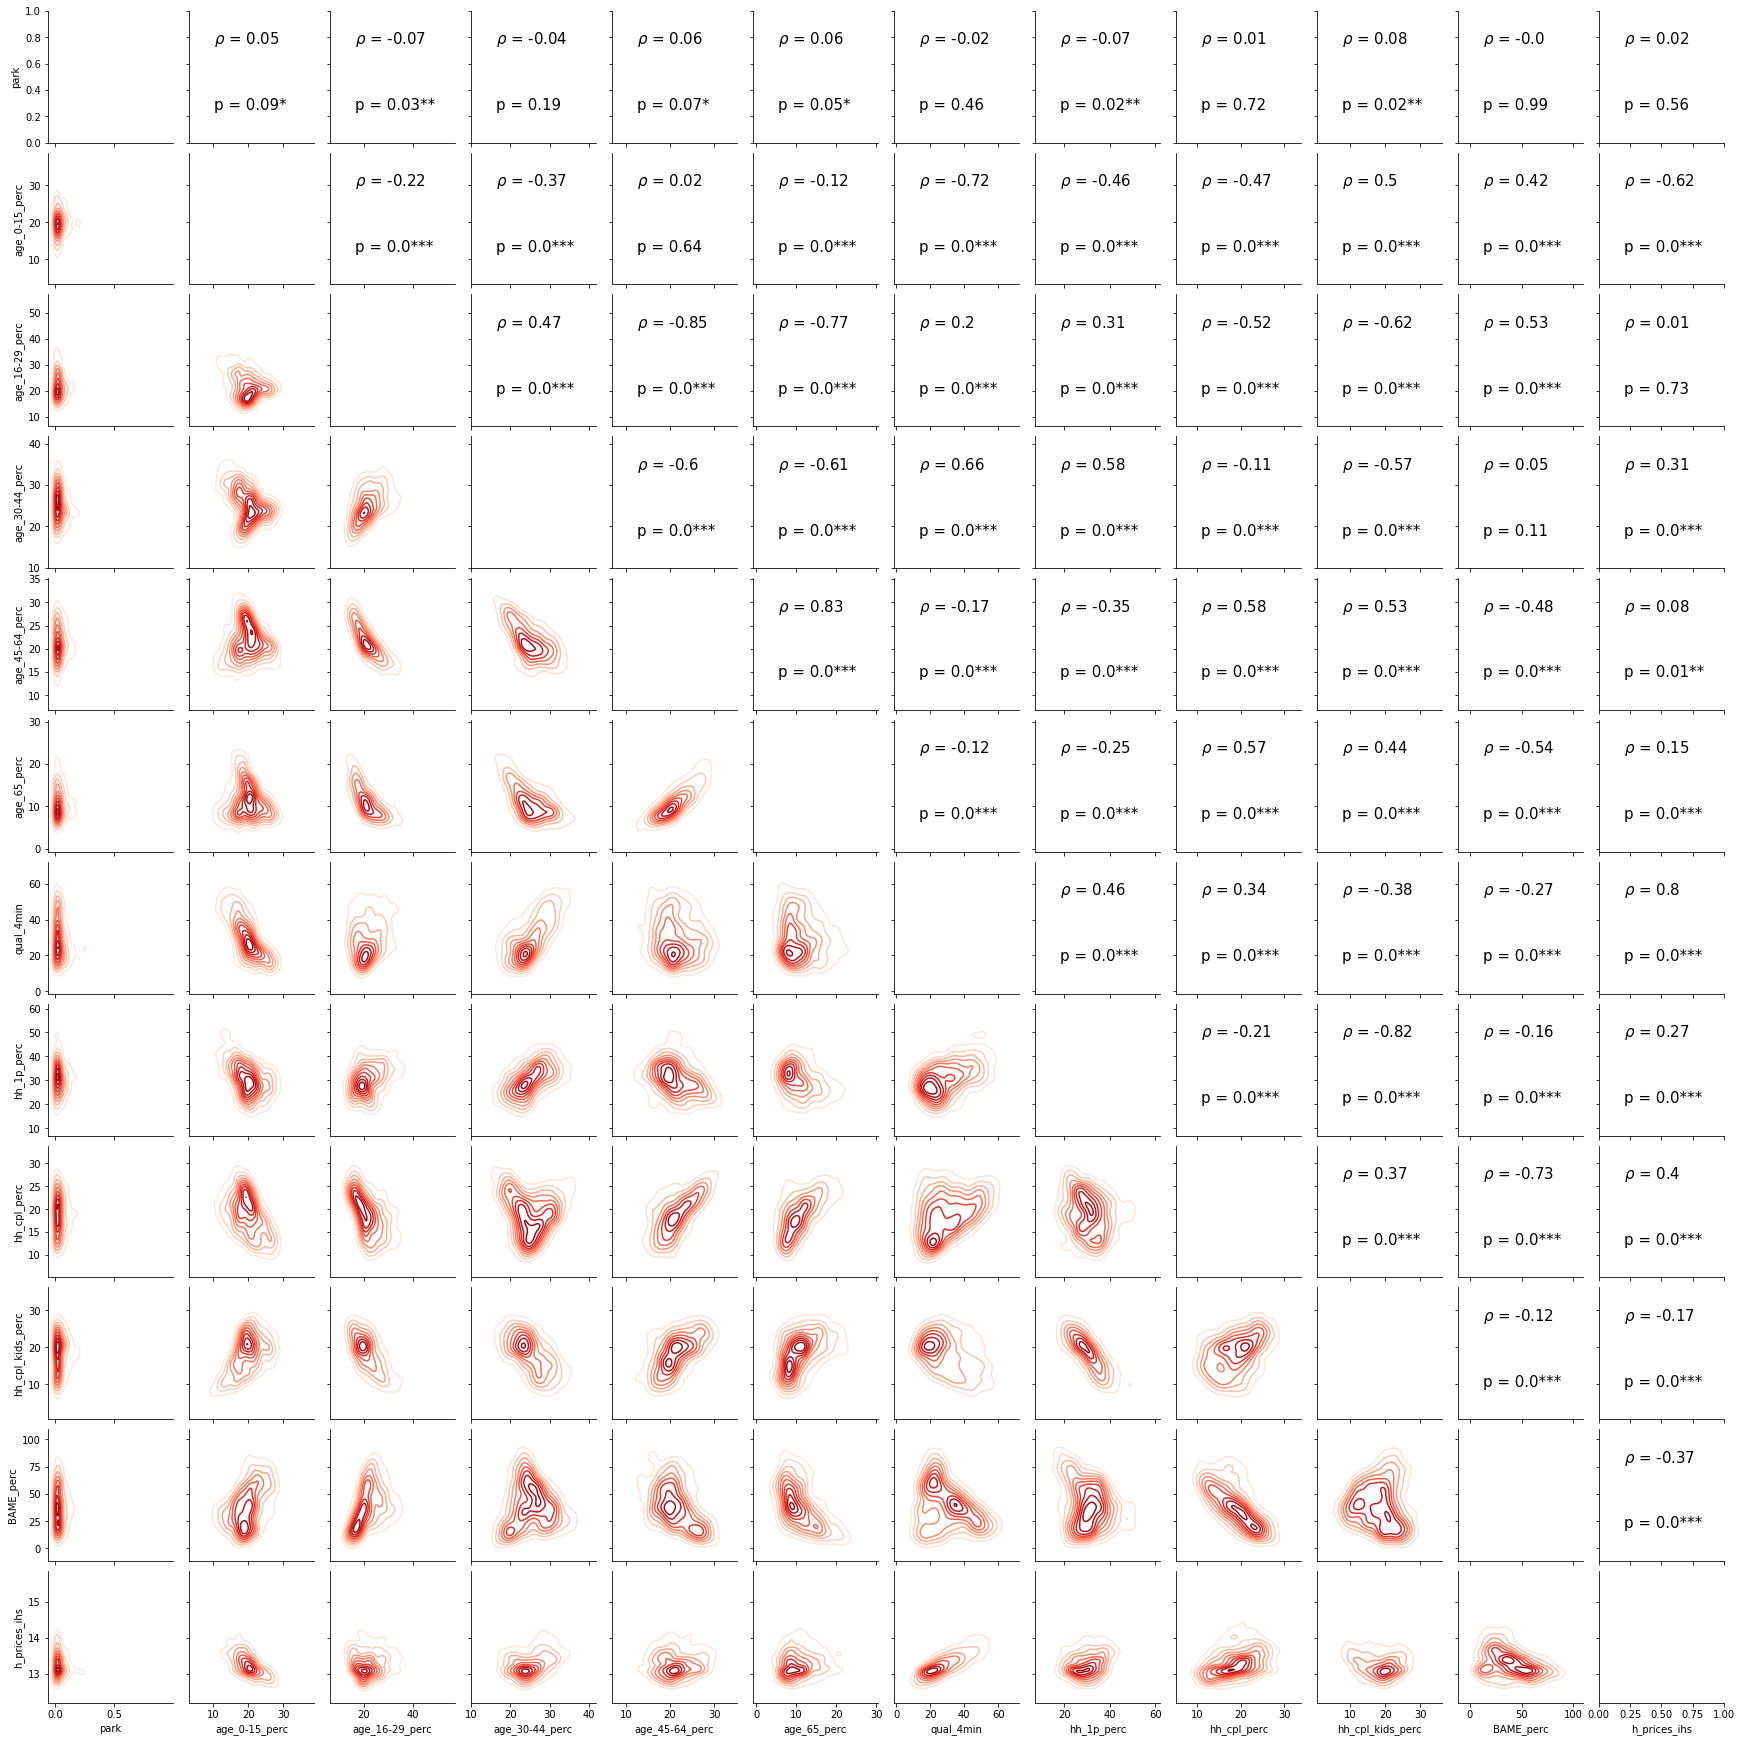

In [4]:
#create dataframe for analysis
df = pd.merge(gt_gdf, msoa_data_selected, how='left', left_on='code', right_on='MSOA Code')
df = df.loc[:, ['code', 'park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012']]
df['h_prices_ihs'] = np.arcsinh(df['house_price_2012'])
display(df.head())

#creates overview figure of correlations.

def corr(x, y, **kwargs):
    """calculates correlation coefficient between two arrays."""
    # coef = np.corrcoef(x, y)[0][1]
    coef = stats.spearmanr(x, y)
    # coef = stats.pearsonr(x, y)

    # Make the label
    label = r'$\rho$ = ' + str(round(coef[0], 2))
    if round(coef[1], 2) < 0.01:
        stars = '***'
    elif round(coef[1], 2) < 0.05:
        stars = '**'
    elif round(coef[1], 2) < 0.1:
        stars = '*'
    else:
        stars = ''

    label2 = 'p = ' + str(round(coef[1], 2)) + stars

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.75), size=15, xycoords=ax.transAxes)
    ax.annotate(label2, xy=(0.2, 0.25), size=15, xycoords=ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data=df,
                    vars=['park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs'],
                    height=2)

# Map the plots to the locations
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap='Reds')

                            OLS Regression Results                            
Dep. Variable:                   park   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.247
Date:                Sat, 31 Oct 2020   Prob (F-statistic):              0.274
Time:                        17:04:50   Log-Likelihood:                 248.04
No. Observations:                 983   AIC:                            -480.1
Df Residuals:                     975   BIC:                            -441.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2184      0.347  

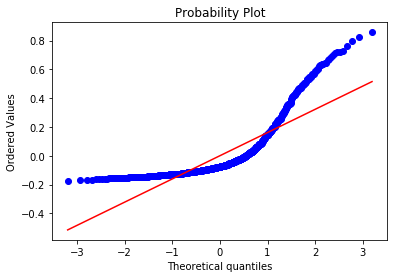

In [22]:
# calculate Global Twitter park model
# using age group with highest correlation
gt_park_skl = linear_model.LinearRegression().fit(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']], df[['park']])
X = sm.add_constant(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']])
gt_park_sm = sm.OLS(df[['park']], X).fit()
print(gt_park_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(gt_park_sm.resid))
res = stats.probplot(gt_park_sm.resid, plot=plt)
plt.show()

## Global Flickr

,code,park,age_0-15_perc,age_16-29_perc,age_30-44_perc,age_45-64_perc,age_65_perc,qual_4min,hh_1p_perc,hh_cpl_perc,hh_cpl_kids_perc,BAME_perc,house_price_2012,h_prices_ihs
0,E02000235,0.019078,21.039036,14.466131,20.335821,29.219288,14.939724,28.315155,21.826281,26.688938,25.835189,18.671068,300000.0,13.304685
1,E02000851,0.075190,17.563025,19.843938,27.587035,20.504202,14.501801,23.889556,43.826257,18.496828,14.982919,24.909964,181000.0,12.799399
2,E02000850,0.692285,20.690659,16.160636,22.233000,27.577845,13.337860,19.924338,25.439683,24.201139,25.687392,23.513435,247650.0,13.112919
3,E02000855,0.176221,19.725183,15.179145,20.020547,28.033903,17.041223,28.945679,25.271829,23.789127,26.326194,16.977013,365000.0,13.500800
4,E02000849,0.831500,20.587842,17.368069,23.740815,25.718103,12.585170,22.471610,29.912875,23.039690,22.265247,19.345357,250000.0,13.122363


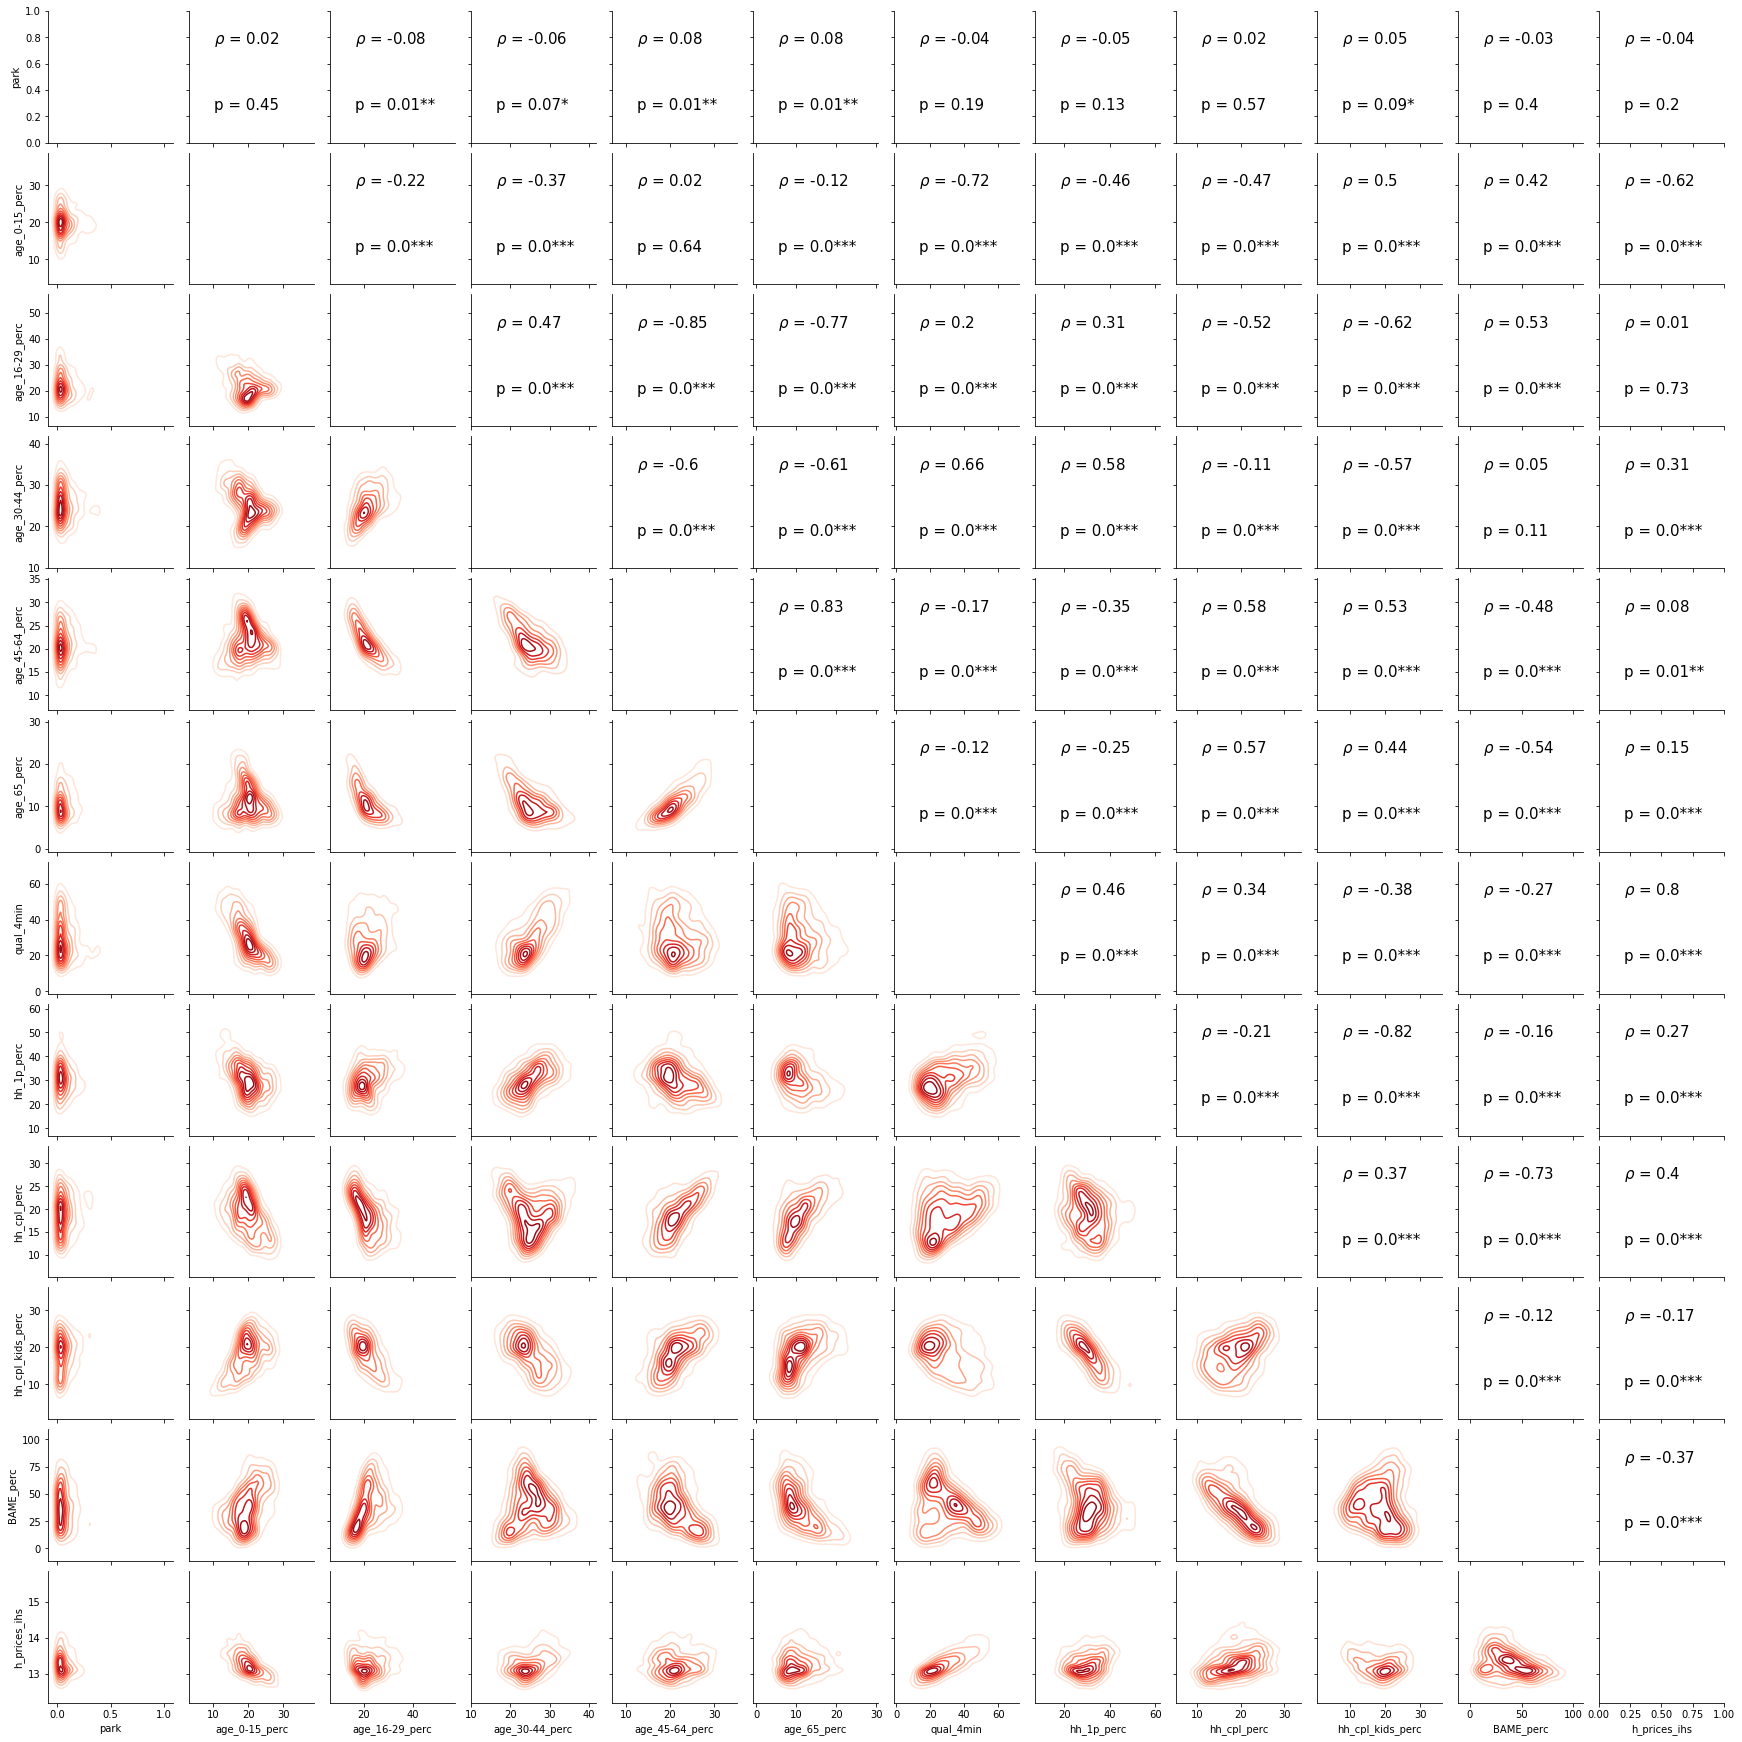

In [5]:
#create dataframe for analysis
df = pd.merge(gf_gdf, msoa_data_selected, how='left', left_on='code', right_on='MSOA Code')
df = df.loc[:, ['code', 'park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012']]
df['h_prices_ihs'] = np.arcsinh(df['house_price_2012'])
display(df.head())

#creates overview figure of correlations.

def corr(x, y, **kwargs):
    """calculates correlation coefficient between two arrays."""
    # coef = np.corrcoef(x, y)[0][1]
    coef = stats.spearmanr(x, y)
    # coef = stats.pearsonr(x, y)

    # Make the label
    label = r'$\rho$ = ' + str(round(coef[0], 2))
    if round(coef[1], 2) < 0.01:
        stars = '***'
    elif round(coef[1], 2) < 0.05:
        stars = '**'
    elif round(coef[1], 2) < 0.1:
        stars = '*'
    else:
        stars = ''

    label2 = 'p = ' + str(round(coef[1], 2)) + stars

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.75), size=15, xycoords=ax.transAxes)
    ax.annotate(label2, xy=(0.2, 0.25), size=15, xycoords=ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data=df,
                    vars=['park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs'],
                    height=2)

# Map the plots to the locations
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap='Reds')

                            OLS Regression Results                            
Dep. Variable:                   park   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.247
Date:                Sat, 31 Oct 2020   Prob (F-statistic):              0.274
Time:                        17:06:20   Log-Likelihood:                 248.04
No. Observations:                 983   AIC:                            -480.1
Df Residuals:                     975   BIC:                            -441.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2184      0.347  

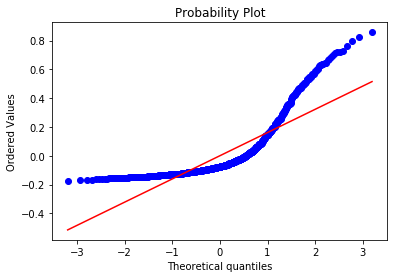

In [23]:
#calculate Global Twitter park model\
# using age group with highest correlation and same as for Twitter
gf_park_skl = linear_model.LinearRegression().fit(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']], df[['park']])
X = sm.add_constant(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']])
gf_park_sm = sm.OLS(df[['park']], X).fit()
print(gf_park_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(gf_park_sm.resid))
res = stats.probplot(gf_park_sm.resid, plot=plt)
plt.show()

## Local Twitter

,code,park,age_0-15_perc,age_16-29_perc,age_30-44_perc,age_45-64_perc,age_65_perc,qual_4min,hh_1p_perc,hh_cpl_perc,hh_cpl_kids_perc,BAME_perc,house_price_2012,h_prices_ihs
0,E02000235,0.017196,21.039036,14.466131,20.335821,29.219288,14.939724,28.315155,21.826281,26.688938,25.835189,18.671068,300000.0,13.304685
1,E02000851,0.029914,17.563025,19.843938,27.587035,20.504202,14.501801,23.889556,43.826257,18.496828,14.982919,24.909964,181000.0,12.799399
2,E02000850,0.042194,20.690659,16.160636,22.233000,27.577845,13.337860,19.924338,25.439683,24.201139,25.687392,23.513435,247650.0,13.112919
3,E02000855,0.210026,19.725183,15.179145,20.020547,28.033903,17.041223,28.945679,25.271829,23.789127,26.326194,16.977013,365000.0,13.500800
4,E02000849,0.319658,20.587842,17.368069,23.740815,25.718103,12.585170,22.471610,29.912875,23.039690,22.265247,19.345357,250000.0,13.122363


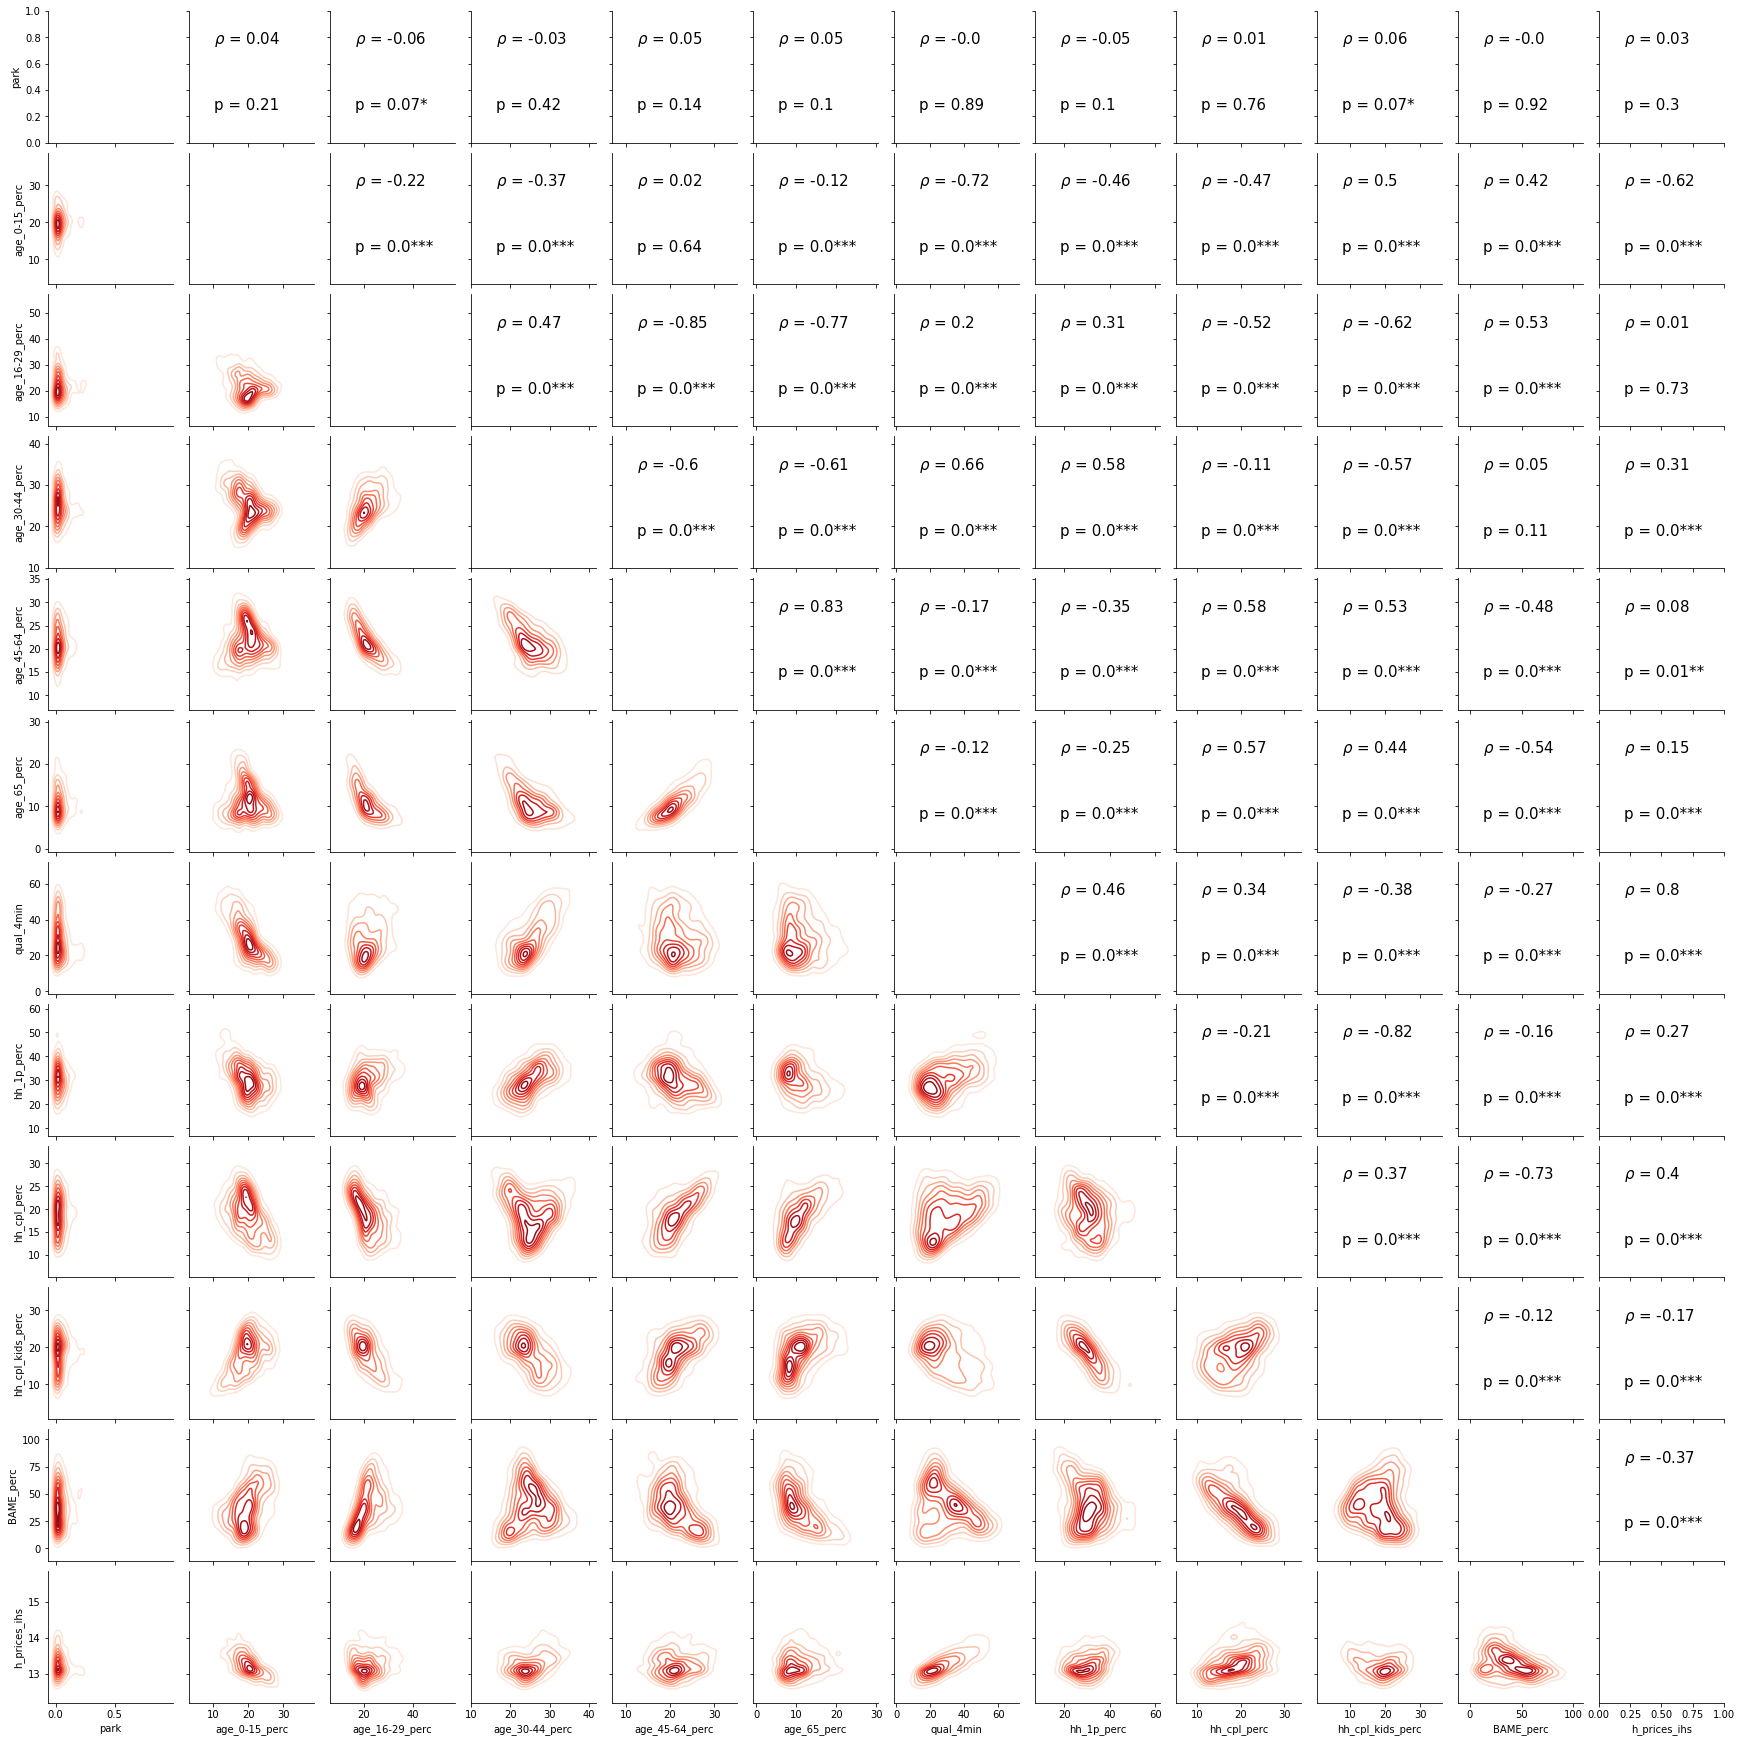

In [6]:
#create dataframe for analysis
df = pd.merge(lt_gdf, msoa_data_selected, how='left', left_on='code', right_on='MSOA Code')
df = df.loc[:, ['code', 'park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012']]
df['h_prices_ihs'] = np.arcsinh(df['house_price_2012'])
display(df.head())

#creates overview figure of correlations.

def corr(x, y, **kwargs):
    """calculates correlation coefficient between two arrays."""
    # coef = np.corrcoef(x, y)[0][1]
    coef = stats.spearmanr(x, y)
    # coef = stats.pearsonr(x, y)

    # Make the label
    label = r'$\rho$ = ' + str(round(coef[0], 2))
    if round(coef[1], 2) < 0.01:
        stars = '***'
    elif round(coef[1], 2) < 0.05:
        stars = '**'
    elif round(coef[1], 2) < 0.1:
        stars = '*'
    else:
        stars = ''

    label2 = 'p = ' + str(round(coef[1], 2)) + stars

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.75), size=15, xycoords=ax.transAxes)
    ax.annotate(label2, xy=(0.2, 0.25), size=15, xycoords=ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data=df,
                    vars=['park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs'],
                    height=2)

# Map the plots to the locations
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap='Reds')

                            OLS Regression Results                            
Dep. Variable:                   park   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.998
Date:                Sat, 31 Oct 2020   Prob (F-statistic):            0.00405
Time:                        17:10:11   Log-Likelihood:                 314.42
No. Observations:                 983   AIC:                            -612.8
Df Residuals:                     975   BIC:                            -573.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.5486      0.325  

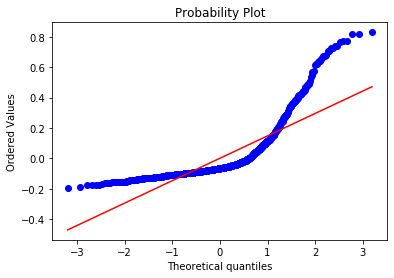

In [25]:
# calculate Local Twitter park model
# using same age group with highest correlation
lt_park_skl = linear_model.LinearRegression().fit(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']], df[['park']])
X = sm.add_constant(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']])
lt_park_sm = sm.OLS(df[['park']], X).fit()
print(lt_park_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(lt_park_sm.resid))
res = stats.probplot(lt_park_sm.resid, plot=plt)
plt.show()

## Local Flickr

,code,park,age_0-15_perc,age_16-29_perc,age_30-44_perc,age_45-64_perc,age_65_perc,qual_4min,hh_1p_perc,hh_cpl_perc,hh_cpl_kids_perc,BAME_perc,house_price_2012,h_prices_ihs
0,E02000235,0.022391,21.039036,14.466131,20.335821,29.219288,14.939724,28.315155,21.826281,26.688938,25.835189,18.671068,300000.0,13.304685
1,E02000851,0.079865,17.563025,19.843938,27.587035,20.504202,14.501801,23.889556,43.826257,18.496828,14.982919,24.909964,181000.0,12.799399
2,E02000850,0.683265,20.690659,16.160636,22.233000,27.577845,13.337860,19.924338,25.439683,24.201139,25.687392,23.513435,247650.0,13.112919
3,E02000855,0.174404,19.725183,15.179145,20.020547,28.033903,17.041223,28.945679,25.271829,23.789127,26.326194,16.977013,365000.0,13.500800
4,E02000849,0.864339,20.587842,17.368069,23.740815,25.718103,12.585170,22.471610,29.912875,23.039690,22.265247,19.345357,250000.0,13.122363


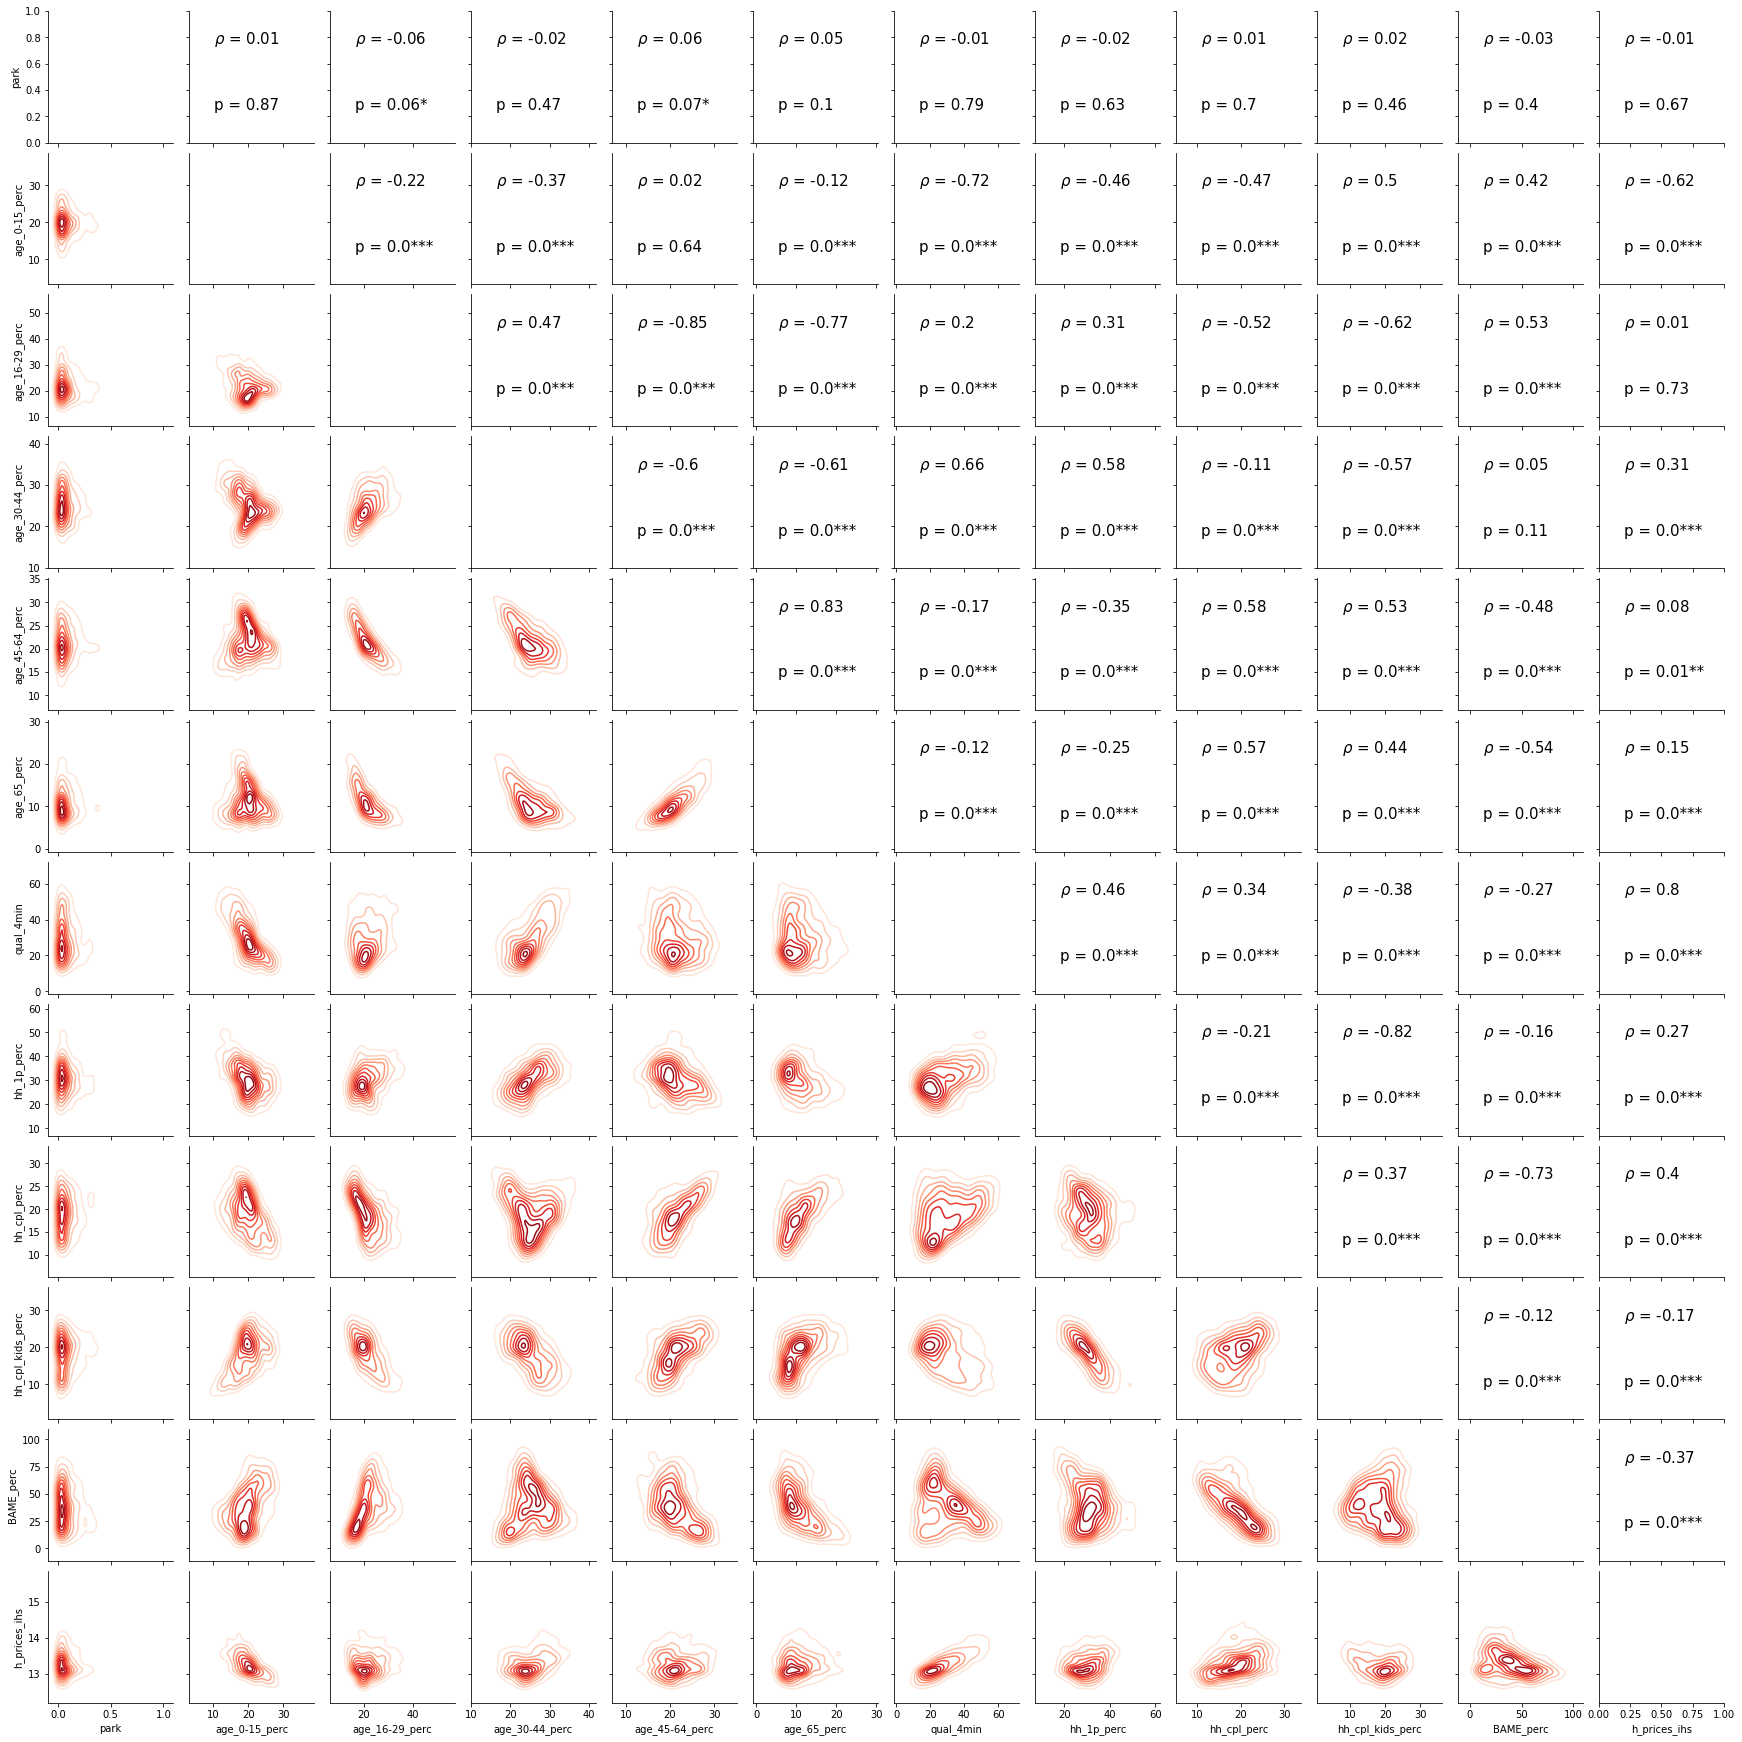

In [7]:
#create dataframe for analysis
df = pd.merge(lf_gdf, msoa_data_selected, how='left', left_on='code', right_on='MSOA Code')
df = df.loc[:, ['code', 'park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'house_price_2012']]
df['h_prices_ihs'] = np.arcsinh(df['house_price_2012'])
display(df.head())

#creates overview figure of correlations.

def corr(x, y, **kwargs):
    """calculates correlation coefficient between two arrays."""
    # coef = np.corrcoef(x, y)[0][1]
    coef = stats.spearmanr(x, y)
    # coef = stats.pearsonr(x, y)

    # Make the label
    label = r'$\rho$ = ' + str(round(coef[0], 2))
    if round(coef[1], 2) < 0.01:
        stars = '***'
    elif round(coef[1], 2) < 0.05:
        stars = '**'
    elif round(coef[1], 2) < 0.1:
        stars = '*'
    else:
        stars = ''

    label2 = 'p = ' + str(round(coef[1], 2)) + stars

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.75), size=15, xycoords=ax.transAxes)
    ax.annotate(label2, xy=(0.2, 0.25), size=15, xycoords=ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data=df,
                    vars=['park', 'age_0-15_perc', 'age_16-29_perc', 'age_30-44_perc', 'age_45-64_perc', 'age_65_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs'],
                    height=2)

# Map the plots to the locations
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap='Reds')

                            OLS Regression Results                            
Dep. Variable:                   park   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.089
Date:                Sat, 31 Oct 2020   Prob (F-statistic):              0.368
Time:                        17:12:18   Log-Likelihood:                 190.86
No. Observations:                 983   AIC:                            -365.7
Df Residuals:                     975   BIC:                            -326.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2241      0.368  

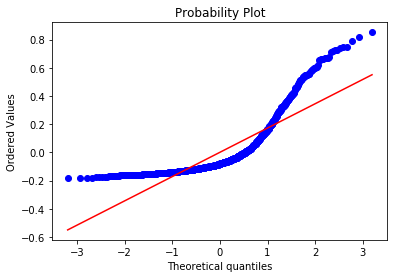

In [27]:
# calculate Local Flickr park model
# using same age group with highest correlation
lf_park_skl = linear_model.LinearRegression().fit(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']], df[['park']])
X = sm.add_constant(df[['age_16-29_perc', 'qual_4min', 'hh_1p_perc', 'hh_cpl_perc', 'hh_cpl_kids_perc', 'BAME_perc', 'h_prices_ihs']])
lf_park_sm = sm.OLS(df[['park']], X).fit()
print(lf_park_sm.summary())

# VIF, Shapiro-Wilkes
print("VIF: ", pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))
print("Shapiro-Wilkes: ", stats.shapiro(lt_park_sm.resid))
res = stats.probplot(lf_park_sm.resid, plot=plt)
plt.show()

# IMD 2019 and *park*

In [ ]:
# import libraries
import psycopg2
import geopandas as gpd
import pandas as pd

conn=psycopg2.connect("")
gdf = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom')
conn.close()

# load overall Flickr scores for MSOAs
flickr_global_top5 = pd.read_csv('flickr_global_overall_top5_scores.csv')
flickr_local_top5 = pd.read_csv('flickr_local_overall_top5_scores.csv')

gf_gdf = pd.merge(gdf, flickr_global_top5, left_on='code', right_on='MSOA')
lf_gdf = pd.merge(gdf, flickr_local_top5, left_on='code', right_on='MSOA')

# load overall Twitter scores for MSOAs
twitter_global_top5 = pd.read_csv('twitter_global_overall_top5_scores.csv')
twitter_local_top5 = pd.read_csv('twitter_local_overall_top5_scores.csv')

gt_gdf = pd.merge(gdf, twitter_global_top5, left_on='code', right_on='MSOA')
lt_gdf = pd.merge(gdf, twitter_local_top5, left_on='code', right_on='MSOA')

# compare 'park' at global and local levels between Flickr and Twitter
gdf['park_gl_diff'] = gf_gdf['park'] - gt_gdf['park']
gdf['park_lo_diff'] = lf_gdf['park'] - lt_gdf['park']

# compare 'road' at global and local levels between Flickr and Twitter
gdf['road_gl_diff'] = gf_gdf['road'] - gt_gdf['road']
gdf['road_lo_diff'] = lf_gdf['road'] - lt_gdf['road']

In [12]:
from scipy import stats

# Correlating with IMD
# first aggregate IMD at MSOA level
lsoa_poly = gpd.read_file("LSOA_2011_London_gen_MHW.shp")
london_imd_2019 = pd.read_csv("ID 2019 for London.csv")
lsoa_imd_poly = pd.merge(lsoa_poly, london_imd_2019, how='left', left_on='LSOA11CD', right_on='LSOA code (2011)')
lsoa_imd_poly = lsoa_imd_poly.filter(items=['LSOA11CD', 'MSOA11CD', 'Index of Multiple Deprivation (IMD) Score', 'geometry'])
lsoa_imd_poly = lsoa_imd_poly.rename(columns={"Index of Multiple Deprivation (IMD) Score": "IMD_2019"})
lsoa_mean = lsoa_imd_poly.groupby('MSOA11CD')['IMD_2019'].aggregate('mean')

# then correlate using Spearman and Pearson
gt_gdf = pd.merge(gt_gdf, lsoa_mean, left_on='code', right_on='MSOA11CD')
print('Global Twitter: park')
print(stats.spearmanr(gt_gdf['park'], gt_gdf['IMD_2019']))
print(stats.pearsonr(gt_gdf['park'], gt_gdf['IMD_2019']))

lt_gdf = pd.merge(lt_gdf, lsoa_mean, left_on='code', right_on='MSOA11CD')
print('Local Twitter: park')
print(stats.spearmanr(lt_gdf['park'], lt_gdf['IMD_2019']))
print(stats.pearsonr(lt_gdf['park'], lt_gdf['IMD_2019']))

gf_gdf = pd.merge(gf_gdf, lsoa_mean, left_on='code', right_on='MSOA11CD')
print('Global Flickr: park')
print(stats.spearmanr(gf_gdf['park'], gf_gdf['IMD_2019']))
print(stats.pearsonr(gf_gdf['park'], gf_gdf['IMD_2019']))

lf_gdf = pd.merge(lf_gdf, lsoa_mean, left_on='code', right_on='MSOA11CD')
print('Local Flickr: park')
print(stats.spearmanr(lf_gdf['park'], lf_gdf['IMD_2019']))
print(stats.pearsonr(lf_gdf['park'], lf_gdf['IMD_2019']))

Global Twitter: park
SpearmanrResult(correlation=-0.038497982723386934, pvalue=0.2278436996194079)
(-0.06746676616778134, 0.03443055622650214)
Local Twitter: park
SpearmanrResult(correlation=-0.03791320573430698, pvalue=0.234990695488086)
(-0.06528071445528412, 0.04072548348939059)
Global Flickr: park
SpearmanrResult(correlation=-0.02561243835399083, pvalue=0.4224764346150569)
(-0.03039696954320046, 0.34107748940389876)
Local Flickr: park
SpearmanrResult(correlation=-0.02099250275260098, pvalue=0.5109177128508874)
(-0.02117470419753001, 0.5072559056219431)
